# POSTPROCESSING OF LOSS MEASUREMENTS



## Extract from Excel

In [32]:
#read the files from BST-L
import pandas as pd
import numpy as np
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
from pymoo.optimize import minimize
from pymoo.core.callback import Callback
import matplotlib.pyplot as plt

# File paths
file_paths = {
    "A": "LAMS/LAMS/20Hz-2kHz_BMT4679_LAM#1_Alvier_21407_BST-SA 20Hz-2kHz_H.xlsx",
    "B": "LAMS/LAMS/20Hz-2kHz_BMT4680_LAM#2_Alvier_21407_BST-SA 20Hz-2kHz_H.xlsx",
    "C": "LAMS/LAMS/20Hz-2kHz_BMT4681_LAM#3_Alvier_21407_BST-SA 20Hz-2kHz_H.xlsx"
}

# Read the Excel files and inspect the first few rows
data_samples = {}
for ids, path in file_paths.items():
    data_samples[ids] = pd.read_excel(path, None)  # Read all sheets

# Display sheet names for each file
sheet_names = {ids: list(data.keys()) for ids, data in data_samples.items()}
sheet_names

{'A': ['Common', 'Results', 'DataPoints', 'DebugInfos'],
 'B': ['Common', 'Results', 'DataPoints', 'DebugInfos'],
 'C': ['Common', 'Results', 'DataPoints', 'DebugInfos']}

In [33]:
# Inspect the "DataPoints" sheet in one file to determine relevant columns
data_points_sample = data_samples["A"]["Results"].head()
data_points_sample

,Measurement,Coil system,Sample,Direction,Signal form,Nominal,Frequency [Hz],Jmax [T],Hmax [A/m],Ps [W/kg],...,Points,E [mJ/kg],µMax,Uflux [V],Tension [MPa],Booster,Status,"Regulator (State|Reverse Pol.|Att,Cap|P|I|OEK|ORW)",Corr.,
0,1.0,BST-SA_48_4,BMT4679_LAM#1,NaN,Sin,1.6 T,20.0,1.600623,3464.514102,1.130664,...,0.0,0.0,0.0,0.0,0.0,1.0,Found,Dig|Cur:False|0.003|0.006|0.003|0.006|0.001|32...,1.0,NaN
1,2.0,BST-SA_48_4,BMT4679_LAM#1,NaN,Sin,1.5 T,20.0,1.498869,1818.961056,0.969463,...,0.0,0.0,0.0,0.0,0.0,1.0,Found,Dig|Cur:False|0.003|0.006|0.003|0.006|0.001|32...,1.0,NaN
2,3.0,BST-SA_48_4,BMT4679_LAM#1,NaN,Sin,1.4 T,20.0,1.400059,963.479111,0.844272,...,0.0,0.0,0.0,0.0,0.0,1.0,Found,Dig|Cur:False|0.003|0.006|0.003|0.006|0.001|32...,1.0,NaN
3,4.0,BST-SA_48_4,BMT4679_LAM#1,NaN,Sin,1.3 T,20.0,1.316826,655.603326,0.751586,...,0.0,0.0,0.0,0.0,0.0,1.0,Found,Dig|Cur:False|0.003|0.006|0.003|0.006|0.001|32...,1.0,NaN
4,5.0,BST-SA_48_4,BMT4679_LAM#1,NaN,Sin,1.2 T,20.0,1.192322,459.990633,0.638442,...,0.0,0.0,0.0,0.0,0.0,1.0,Found,Dig|Cur:False|0.003|0.006|0.003|0.006|0.001|32...,1.0,NaN


In [34]:
# Average the core loss results relative to teh same J and frequency across the excel files
#  Collect all Results data into a single DataFrame with an identifier
results_list = []
for key, sample in data_samples.items():
    df = sample["Results"].copy()
    df["Sample"] = key  # Add a column to identify the source
    results_list.append(df)

# Concatenate all Results data
all_results = pd.concat(results_list, ignore_index=True)

# Remove ' T' from Nominal column if present
all_results['Nominal'] = all_results['Nominal'].astype(str).str.replace(' T', '', regex=False)

# Group by 'Nominal' and 'Frequency [Hz]', then average 'Ps [W/kg]'
res_avg = all_results.groupby(['Nominal', 'Frequency [Hz]'])['Ps [W/kg]'].mean().reset_index()

# Ensure all columns are numeric for optimization
result_avg = res_avg.dropna().astype(float).values


## Optimization definition 

In [35]:
def run_optimization(result_avg, pop_size, n_iter, algorithm_name="CMAES", weight= False):
    """
    Run optimization for the Bertotti core loss model.
    algorithm_name: str, one of ["CMAES", "DE"]
    """
    from pymoo.optimize import minimize
    from pymoo.core.problem import Problem
    import numpy as np
    import matplotlib.pyplot as plt

    # Setup Optimization Problem 
    class loss_opt(Problem):
        def __init__(self, result_avg):
            super().__init__(
                n_var=6,
                n_obj=1,
                n_constr=0,
                # Variable bounds 
                # K_hyst, K_eddy, alpha, beta, gamma, delta  
                xl=np.array([1e-6, 1e-6, 1e-4, 1e-4, 1e-4, 1e-4]),
                xu=np.array([5, 5, 5, 5, 5, 5]),
            )
            self.p = result_avg[:,2]
            self.J = result_avg[:,0]
            self.f = result_avg[:,1]
            self.weight = weight

        def _evaluate(self, x, out, *args, **kwargs):
            x = np.atleast_2d(x)
            # Vectorized computation for all solutions in the population
            kh = x[:, 0][:, None]
            ke = x[:, 1][:, None]
            alpha = x[:, 2][:, None]
            beta = x[:, 3][:, None]
            gamma = x[:, 4][:, None]
            delta = x[:, 5][:, None]
            pm = kh * self.J ** alpha * self.f ** beta + ke * self.J ** gamma * self.f ** delta
            if self.weight == True:
                w = self.p/np.sum(self.p)
            else:
                w = 1
            f = np.sum(w*(self.p - pm) ** 2, axis=1)
            out["F"] = f.reshape(-1, 1)

    # define starting point
    problem = loss_opt(result_avg)
    # Ensure x0 is within bounds
    x0 = problem.xl + (problem.xu - problem.xl) * np.random.random(problem.n_var)

    # Algorithm selection
    algorithm_name = algorithm_name.upper()
    if algorithm_name == "CMAES":
        from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
        algorithm = CMAES(
            x0=x0,
            sigma=0.3,
            popsize=pop_size,     
            restarts=5,
            restart_from_best=True,
            tolfun=1e-6,
            tolx=1e-6,
            bipop=True       
        )
    elif algorithm_name == "DE":
        from pymoo.algorithms.soo.nonconvex.de import DE
        algorithm = DE(
            pop_size=pop_size,
            variant="DE/rand/1/bin",
            CR=0.9,
            F=0.8
        )
    elif algorithm_name == "GA":
        from pymoo.algorithms.soo.nonconvex.ga import GA
        algorithm = GA(
            pop_size=pop_size
        )
    else:
        raise ValueError(f"Unknown algorithm: {algorithm_name}. Supported: 'CMAES', 'DE', 'GA'.")

    # Run optimization and store history
    res = minimize(
        problem,
        algorithm,
        termination=("n_gen",n_iter),
        seed=1,
        save_history=True,  # Store history for plotting
        verbose=False  # Suppress text output
        
    )

    # Do not block after plotting, so the code continues
    plt.show(block=False)    

    # Robust extraction of solution
    if hasattr(res, "x") and hasattr(res, "f"):
        x_best, fit = res.x, res.f
    elif hasattr(res, "X") and hasattr(res, "F"):
        x_best, fit = res.X, res.F
    else:
        raise AttributeError("Result object has neither x/f nor X/F attributes.")

    # Plot best objective value per generation
    if hasattr(res, "history"):
        best_f = [np.min(e.opt.get('F')) for e in res.history if e.opt is not None]
        plt.figure()
        plt.plot(np.arange(1, len(best_f)+1), best_f, 'b-')
        plt.xlabel('Generation')
        plt.ylabel('Best Objective Value')
        plt.yscale('log')
        plt.title(f'{algorithm_name} Progress (Best Objective Value)')
        plt.grid(True)
        # Annotate final value
        final_val = best_f[-1]
        plt.annotate(f'Final: {final_val:.2e}', xy=(len(best_f), final_val),
                     xytext=(-80, 20), textcoords='offset points',
                     arrowprops=dict(arrowstyle='->', color='red'),
                     fontsize=12, color='red', ha='right')
        plt.show()

    return x_best, fit





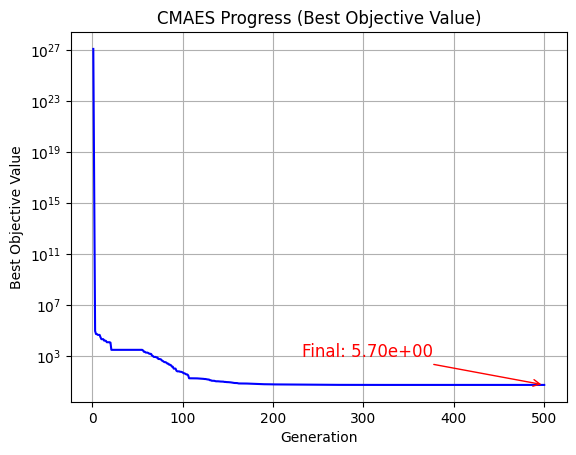

In [36]:
# Only run the optimization, do not print x_best, fit
x_best, fit = run_optimization(result_avg,pop_size=50,n_iter=500, algorithm_name="CMAES",weight=False)

In [37]:
print(f"Kh = {x_best[0]:.3e}")
print(f"Ke = {x_best[1]:.3e}")
print(f"alpha = {x_best[2]:.3e}")
print(f"beta  = {x_best[3]:.3e}")
print(f"gamma = {x_best[4]:.3e}")
print(f"delta = {x_best[5]:.3e}")

Kh = 2.811e-04
Ke = 2.356e-02
alpha = 1.742e+00
beta  = 1.705e+00
gamma = 1.531e+00
delta = 9.840e-01


## Optimization PostProcessing

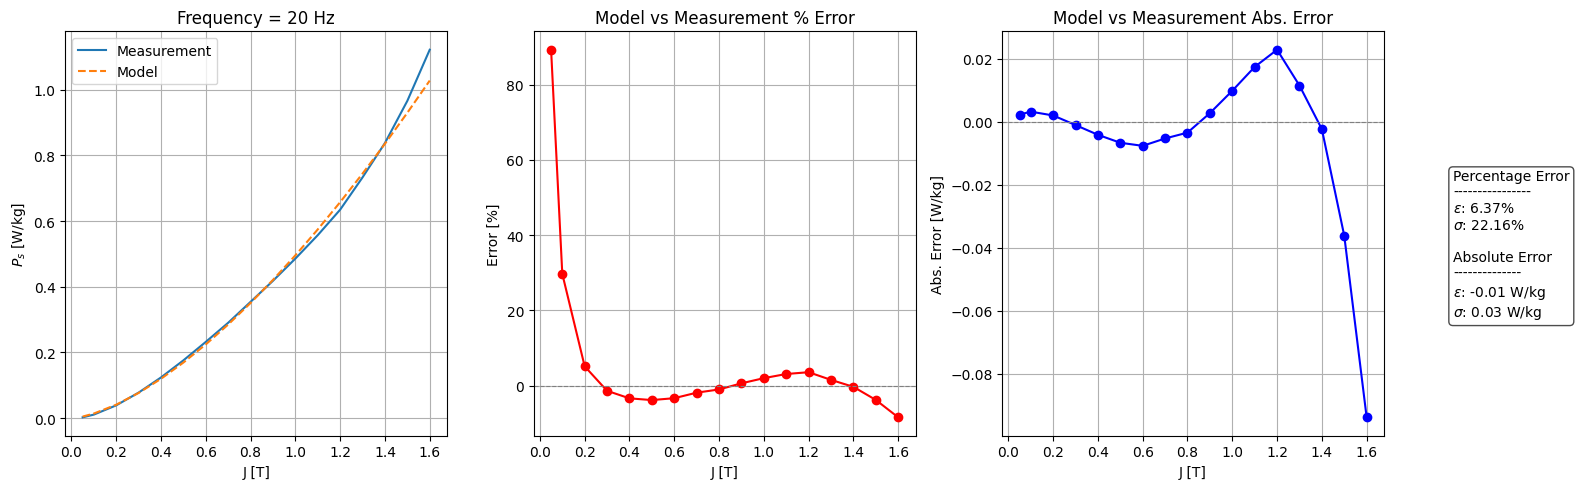

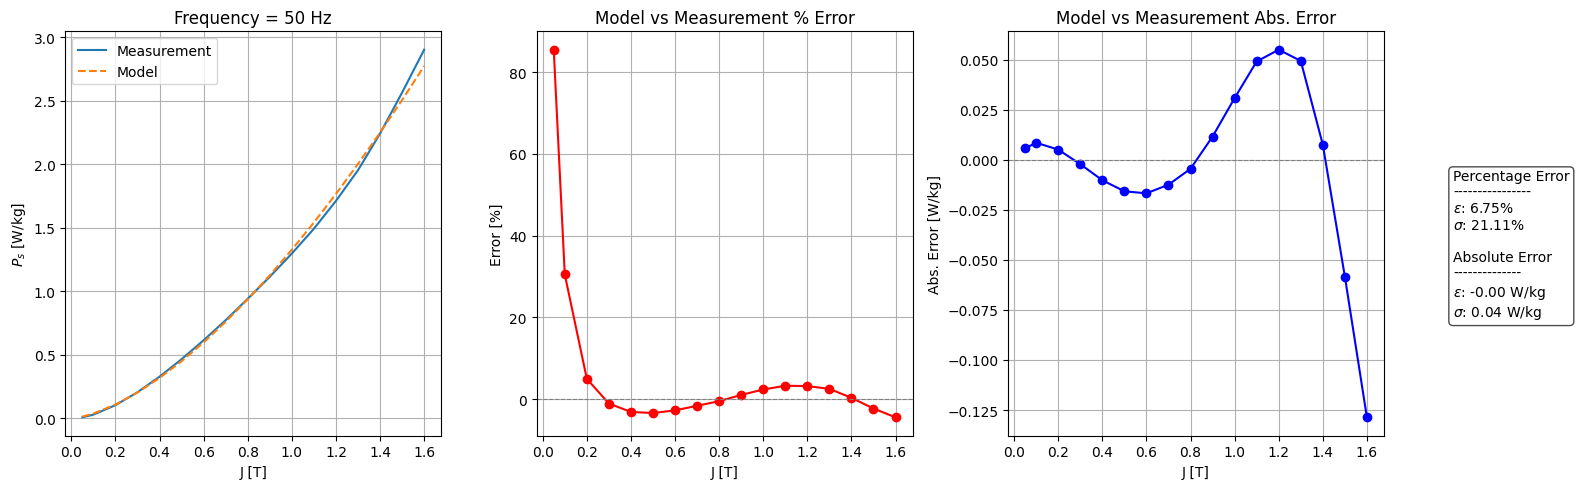

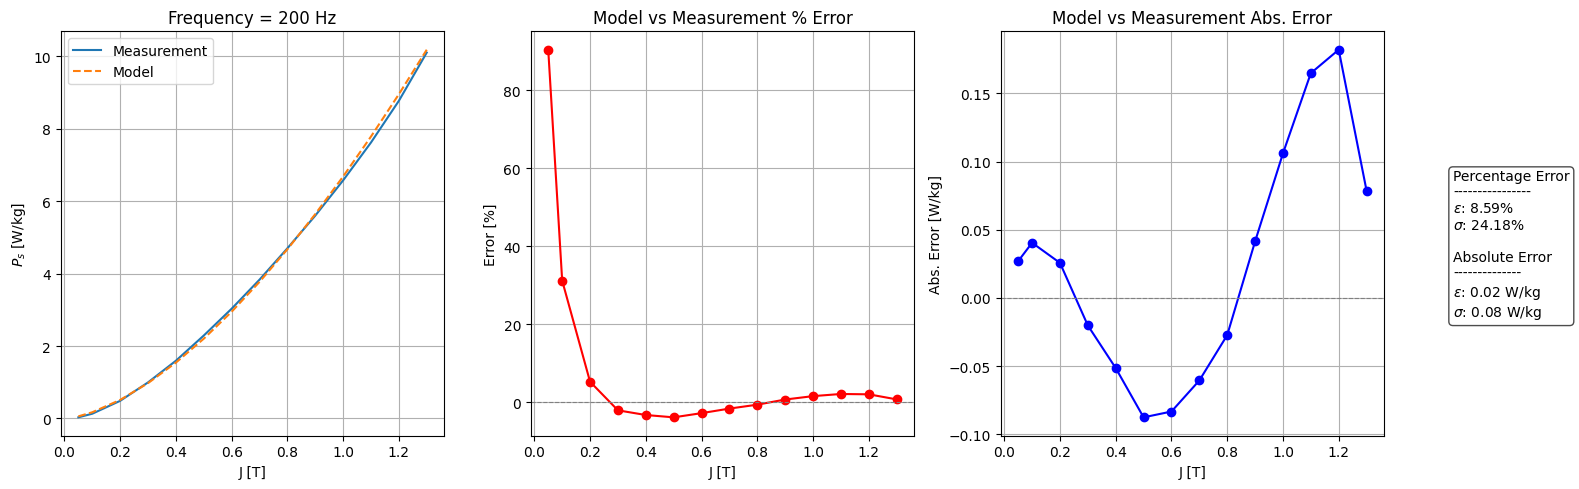

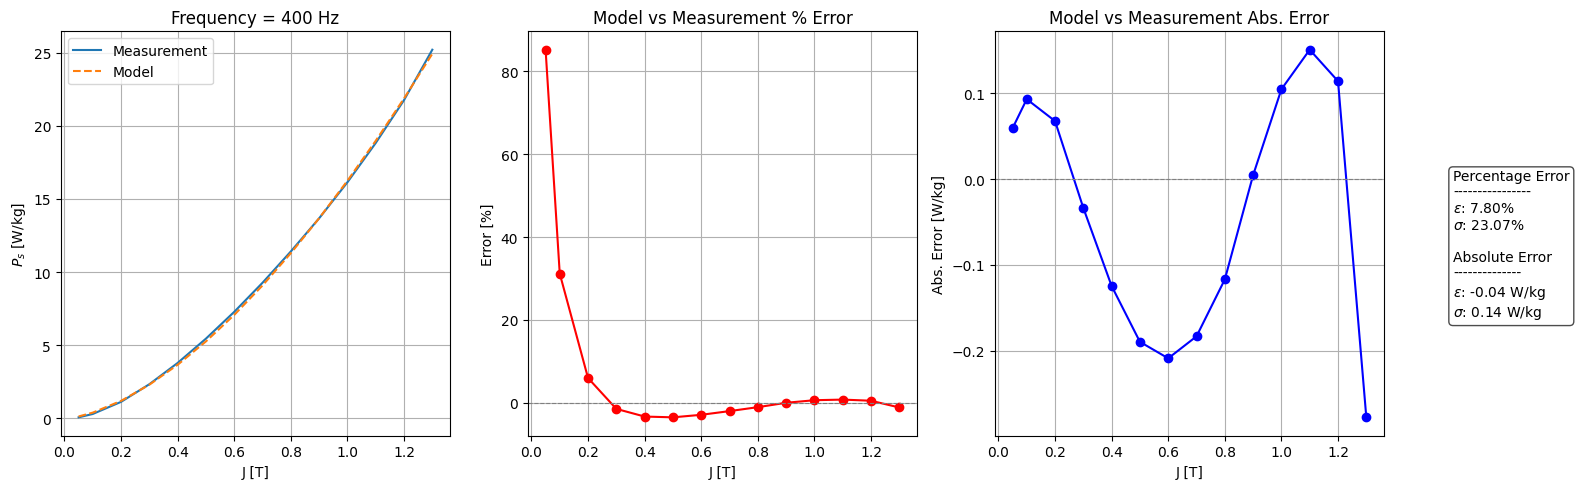

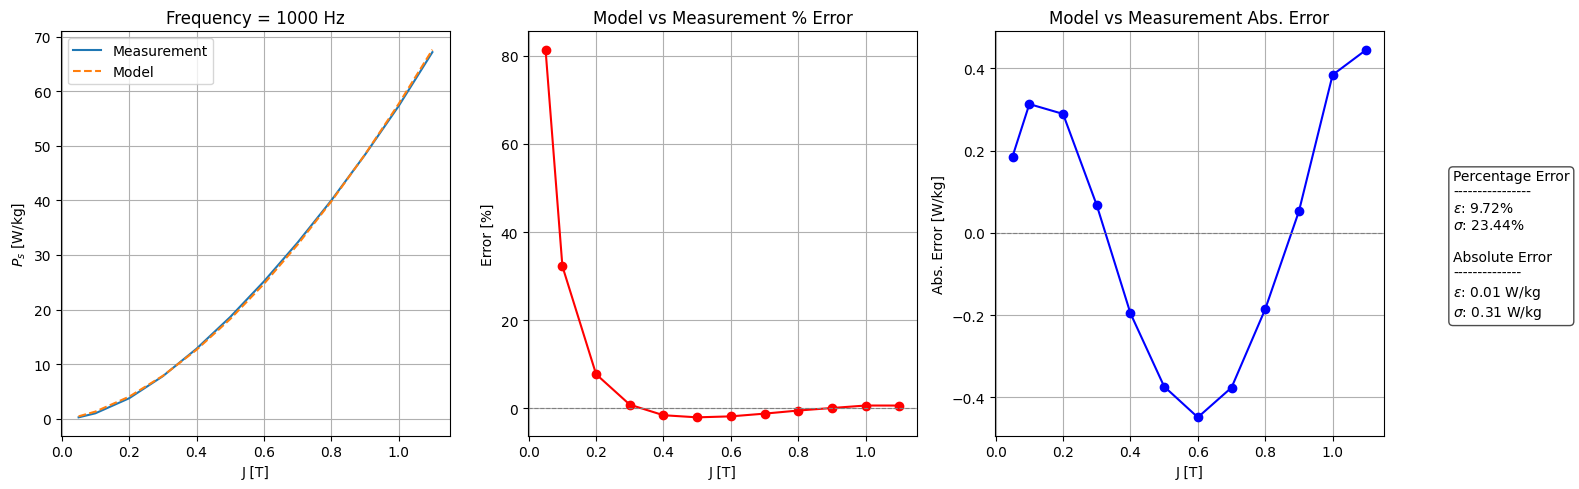

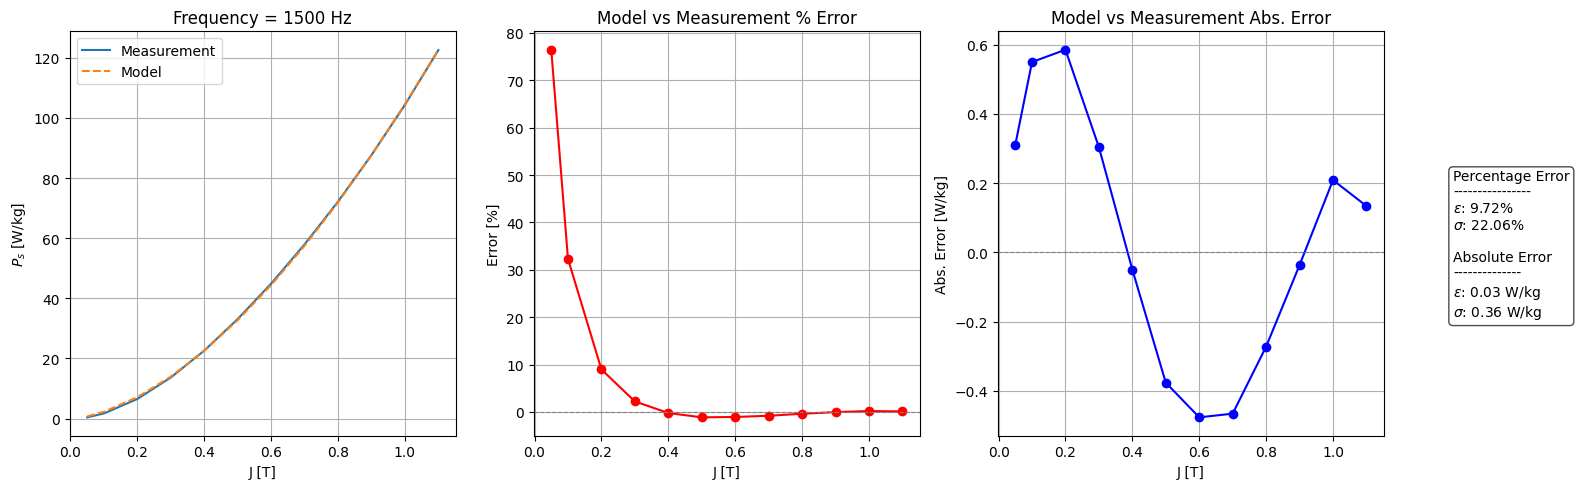

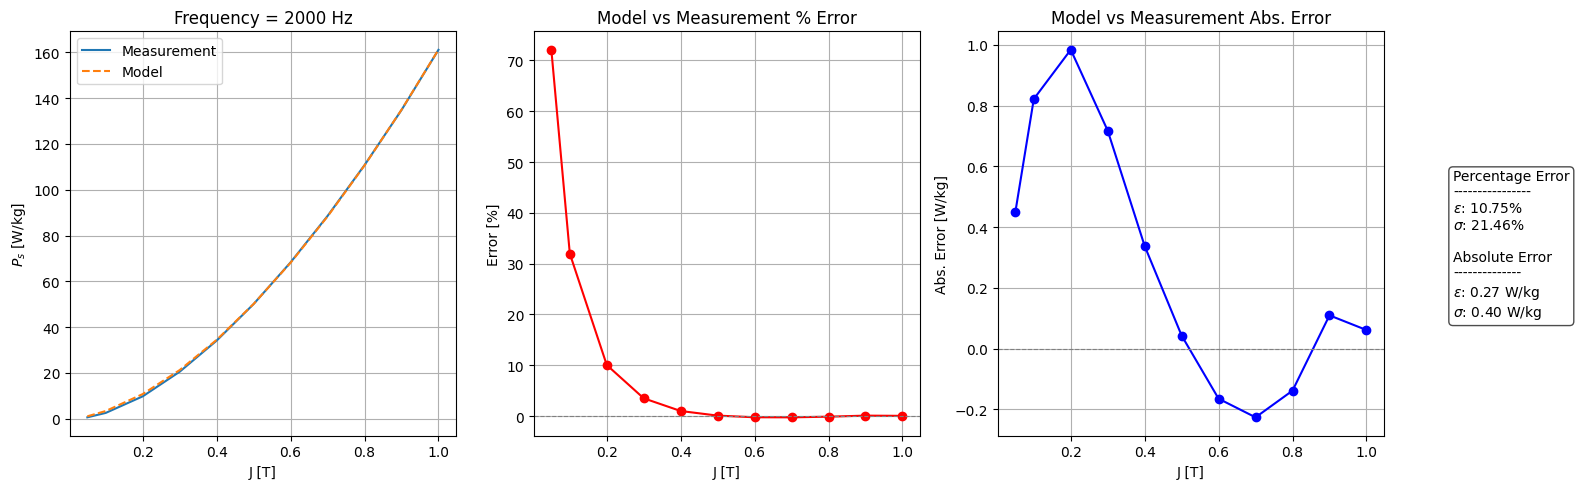

In [38]:
def postProc(x_best, res):
    kh, ke, alpha, beta, gamma, delta = x_best              

    for f_el in np.unique(res[:,1]):
        # extract index for elements in the same frequency
        idx = np.where(res[:, 1] == f_el)[0]
        # compute related losses    
        
        pm = kh * res[idx,0] ** alpha * res[idx,1] ** beta + ke * res[idx,0] ** gamma * res[idx,1] ** delta

    
        # Right: Percentage error
        perc_error = 100 * (pm - res[idx,2]) / res[idx,2]
        abs_error = (pm - res[idx,2]) 

        # Update to 3 subplots, but place a single textbox outside to the right with headers
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))

        # Left: Model vs Measurement
        axs[0].plot(res[idx,0], res[idx,2], label='Measurement')
        axs[0].plot(res[idx,0], pm, label='Model', linestyle='--')
        axs[0].legend()
        axs[0].set_xlabel('J [T]')
        axs[0].set_ylabel(r'$P_s$ [W/kg]')
        axs[0].set_title(f'Frequency = {f_el:.0f} Hz')
        axs[0].tick_params(axis='x', labelrotation=0)
        axs[0].tick_params(axis='y', labelrotation=0)
        axs[0].grid(True)

        # Middle: Percentage error
        axs[1].plot(res[idx,0], perc_error, marker='o', color='r')
        axs[1].set_xlabel('J [T]')
        axs[1].set_ylabel('Error [%]')
        axs[1].set_title('Model vs Measurement % Error')
        axs[1].axhline(0, color='gray', linestyle='--', linewidth=0.8)
        axs[1].tick_params(axis='x', labelrotation=0)
        axs[1].tick_params(axis='y', labelrotation=0)
        axs[1].grid(True)

        # Right: Absolute error
        axs[2].plot(res[idx,0], abs_error, marker='o', color='b')
        axs[2].set_xlabel('J [T]')
        axs[2].set_ylabel('Abs. Error [W/kg]')
        axs[2].set_title('Model vs Measurement Abs. Error')
        axs[2].axhline(0, color='gray', linestyle='--', linewidth=0.8)
        axs[2].tick_params(axis='x', labelrotation=0)
        axs[2].tick_params(axis='y', labelrotation=0)
        axs[2].grid(True)

        # Prepare combined textbox content with headers and Greek letters
        textstr = (
            "Percentage Error\n"
            "----------------\n"
            r"$\epsilon$: {:.2f}%".format(np.mean(perc_error)) + "\n"
            r"$\sigma$: {:.2f}%".format(np.std(perc_error)) + "\n\n"
            "Absolute Error\n"
            "--------------\n"
            r"$\epsilon$: {:.2f} W/kg".format(np.mean(abs_error)) + "\n"
            r"$\sigma$: {:.2f} W/kg".format(np.std(abs_error))
        )

        # Adjust subplot spacing to prevent label overlap
        plt.subplots_adjust(right=0.78, wspace=0.35, bottom=0.18, top=0.88)

        # Place the single combined textbox
        fig.text(0.81, 0.65, textstr, fontsize=10, va='top', ha='left',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

        # Make sure labels/titles do not overlap
        fig.tight_layout(rect=[0, 0, 0.78, 1])

        plt.show()

postProc(x_best, result_avg)



# BUILD FACTOR CALCULATION

In [39]:
# Extract from excel and concatenate all sheets
file_path = "LAMS/hiliteno20-1200h.xlsx"
data_sample = pd.read_excel(file_path, None)

# Display sheet names for the file
sheet_names = list(data_sample.keys())
print("Sheet names:", sheet_names)

# Concatenate all sheets into a single DataFrame
all_data_concat = pd.concat(data_sample.values(), ignore_index=True)

# Swap the second and third columns
cols = list(all_data_concat.columns)
cols[1], cols[2] = cols[2], cols[1]
all_data_swapped = all_data_concat[cols].copy()

# Convert the first three columns to float
for col in all_data_swapped.columns[:3]:
    all_data_swapped[col] = pd.to_numeric(all_data_swapped[col], errors='coerce')

# Convert the first three columns of all_data_swapped to a numpy array
all_data_np = all_data_swapped.iloc[:, :3].dropna().astype(float).values



Sheet names: ['Frequency_50Hz', 'Frequency_100Hz', 'Frequency_200Hz', 'Frequency_400Hz', 'Frequency_700Hz', 'Frequency_1000Hz']


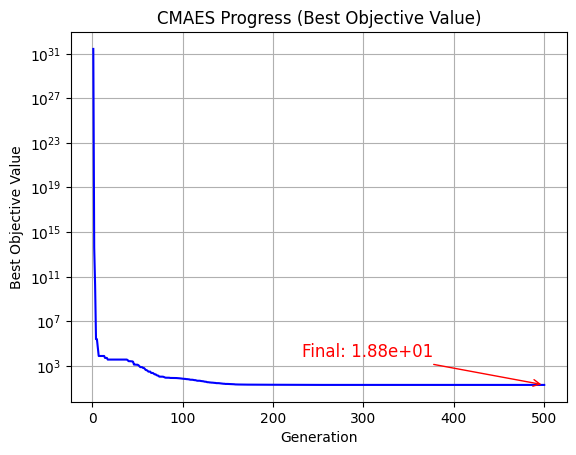

Kh = 7.217e-04
Ke = 1.357e-03
alpha = 4.664e+00
beta  = 1.240e+00
gamma = 1.639e+00
delta = 1.484e+00


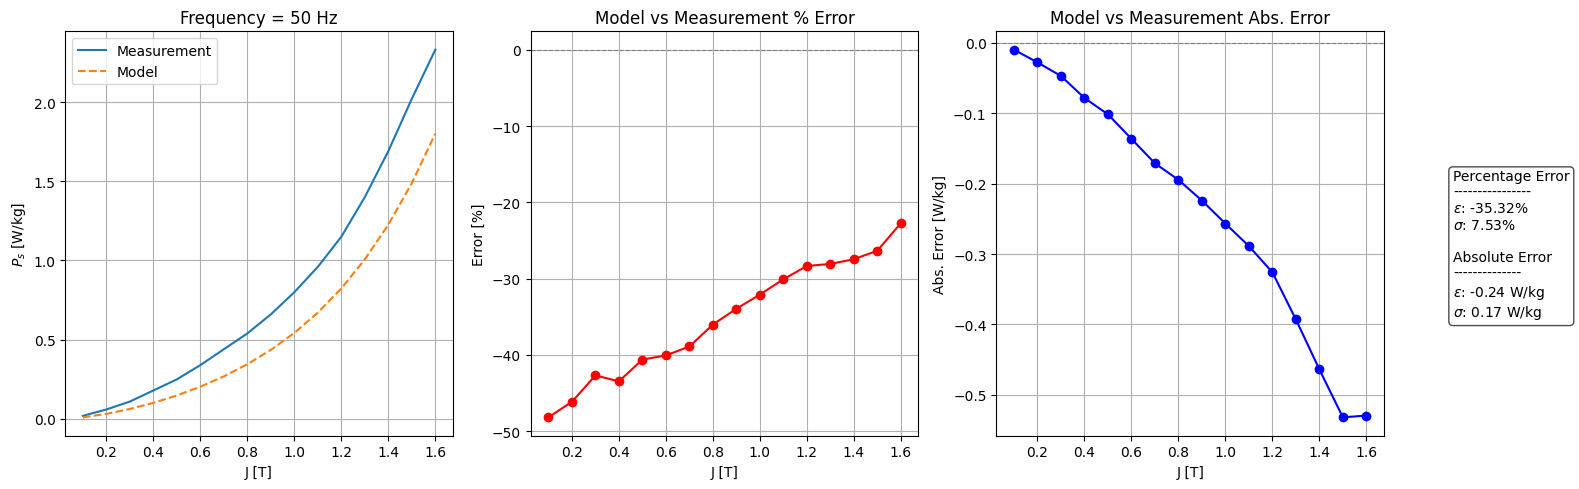

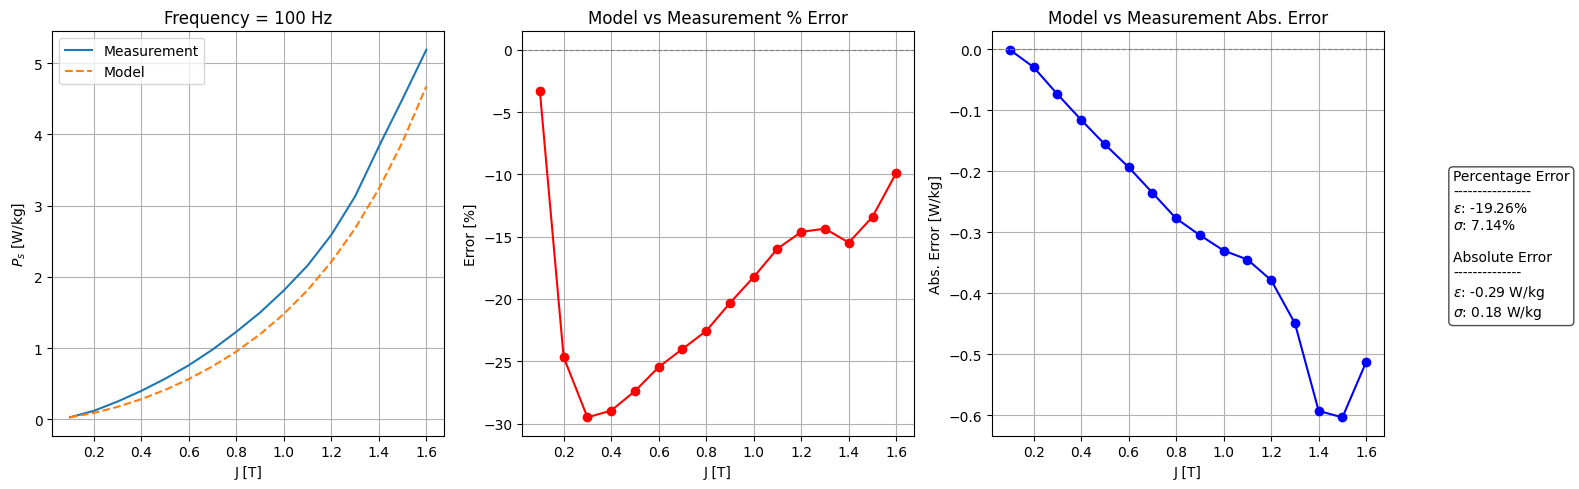

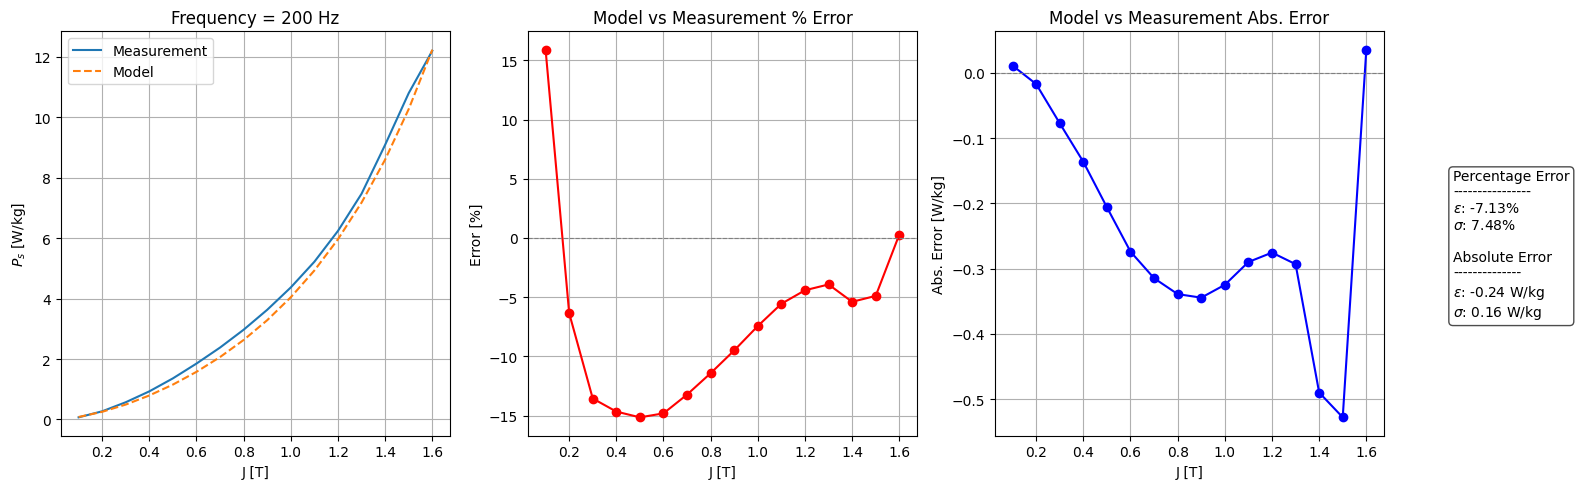

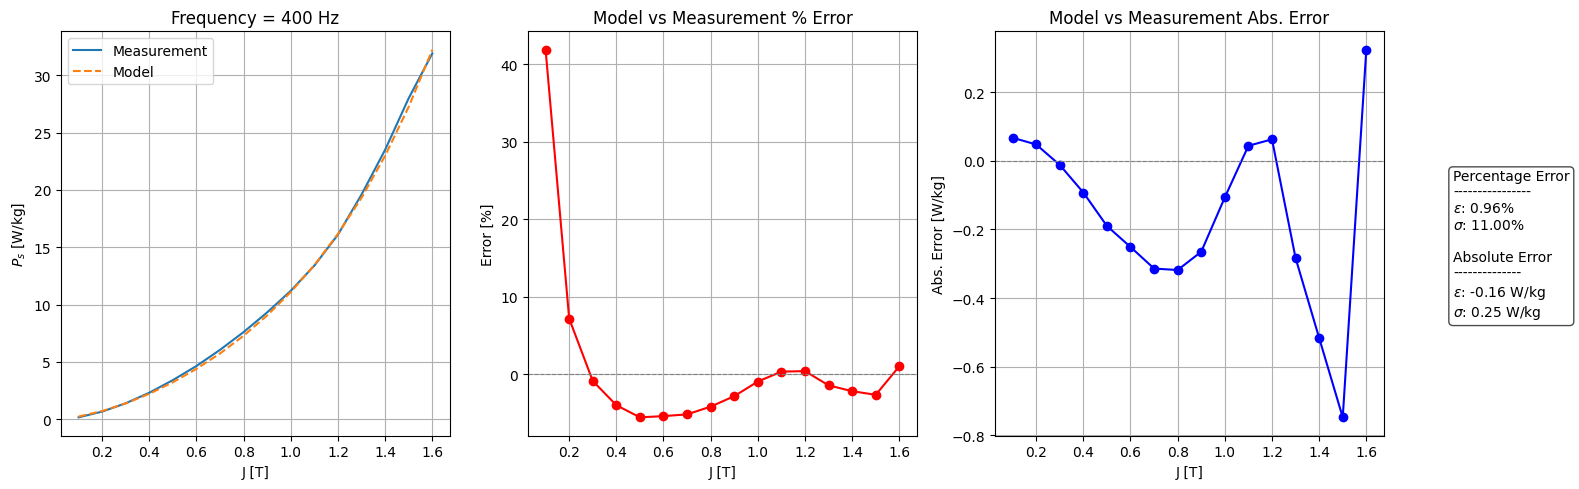

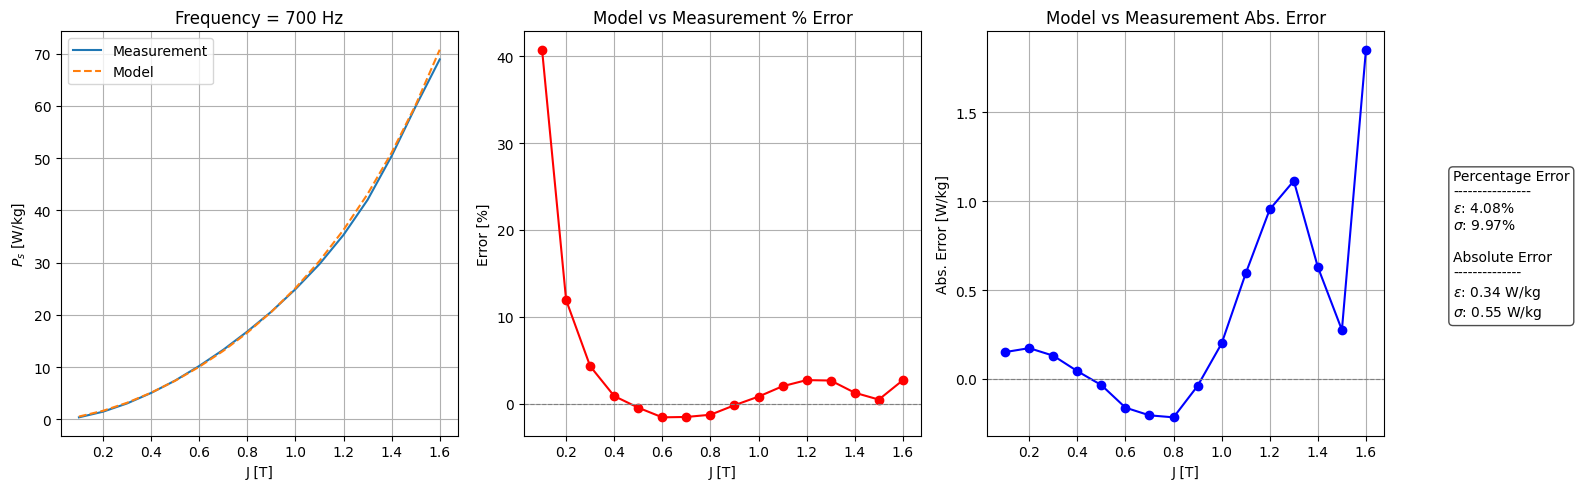

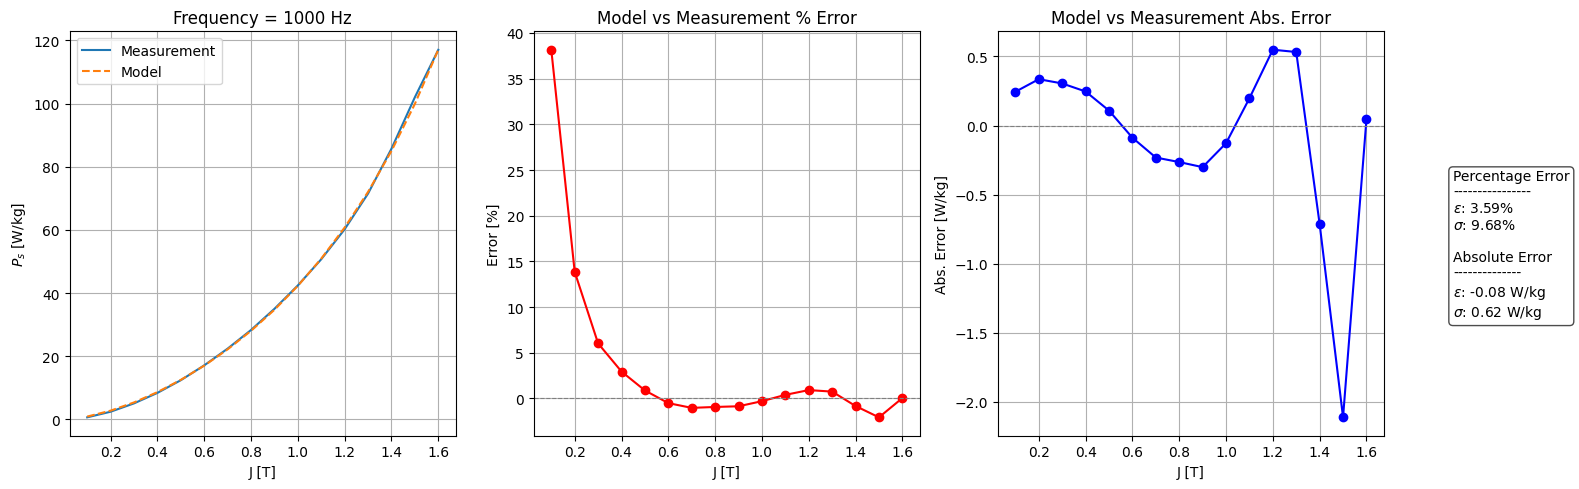

In [40]:
x_EF, fit_EF = run_optimization(all_data_np,pop_size=100,n_iter=500, algorithm_name="CMAES",weight=False)

print(f"Kh = {x_EF[0]:.3e}")
print(f"Ke = {x_EF[1]:.3e}")
print(f"alpha = {x_EF[2]:.3e}")
print(f"beta  = {x_EF[3]:.3e}")
print(f"gamma = {x_EF[4]:.3e}")
print(f"delta = {x_EF[5]:.3e}")

postProc(x_EF, res=all_data_np)

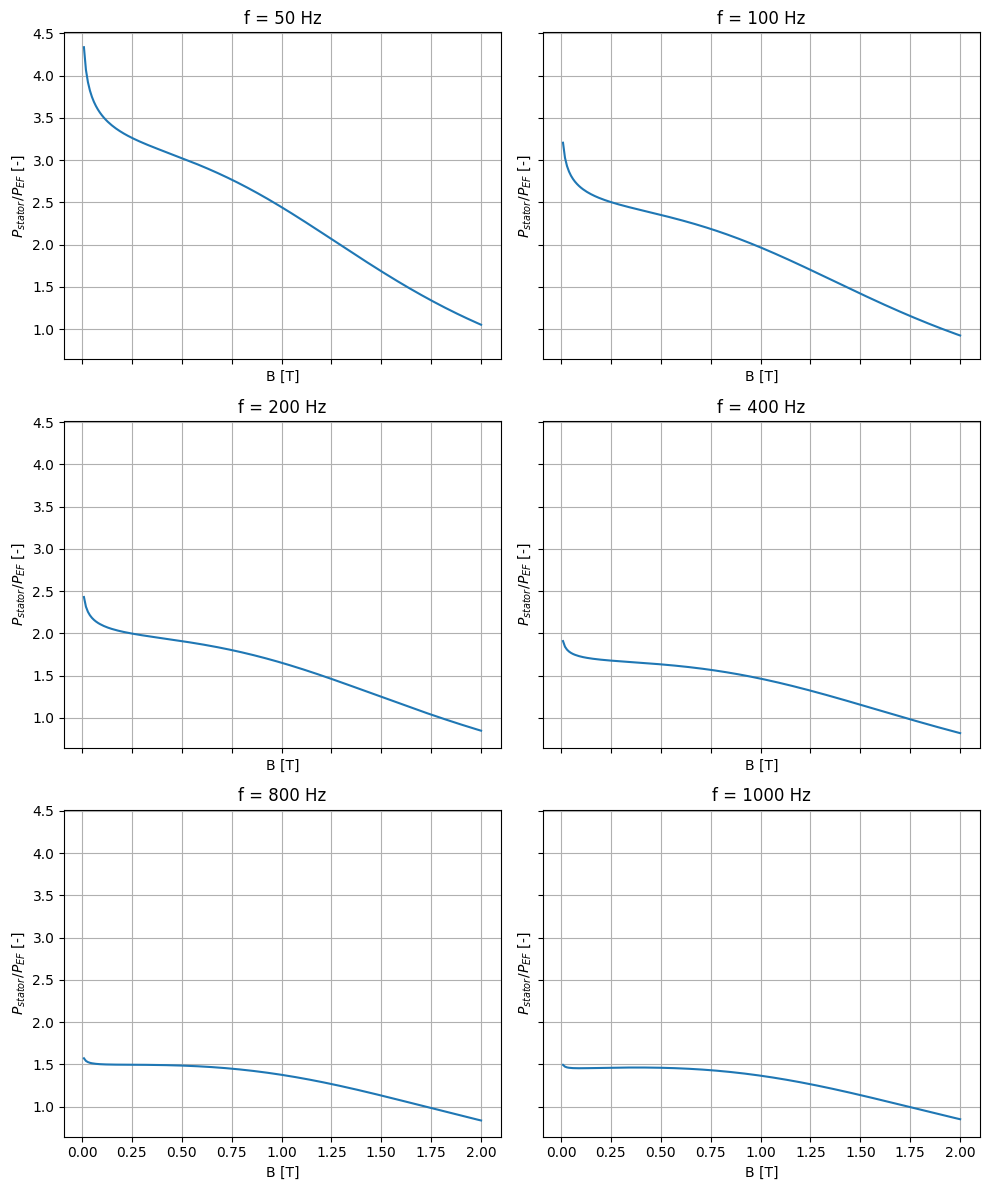

In [41]:
import math
# define frequencies and induction to be evaluated
fel_build = [50, 100, 200, 400, 800, 1000]
B = np.arange(0.01, 2 + 0.01, 0.01)

n = len(fel_build)
ncols = 2
nrows = math.ceil(n / ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=(10, 4*nrows), sharex=True, sharey=True)

for i, val in enumerate(fel_build):
    p_EF = x_EF[0] * B ** x_EF[2] * fel_build[i] ** x_EF[3] + x_EF[1] * B ** x_EF[4] * fel_build[i] ** x_EF[5]
    p_stat = x_best[0] * B ** x_best[2] * fel_build[i] ** x_best[3] + x_best[1] * B ** x_best[4] * fel_build[i] ** x_best[5]

    ax = axs[i // ncols, i % ncols]
    ax.set_title(f"f = {val} Hz")
    ax.plot(B, p_stat/p_EF)
    ax.set_xlabel('B [T]')
    ax.set_ylabel(r'$P_{stator} / P_{EF}$ [-]')
    ax.grid(True)

plt.tight_layout()
plt.savefig('figures/svg/build_factors_no20-1200h.svg')
plt.savefig('figures/png/build_factors_no20-1200h.png', dpi=600)
plt.show()